# Monthly Revenue

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
url = 'data/online_retail.csv'
retail = pd.read_csv(url, encoding='unicode_escape')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail['InvoiceYM'] = retail['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12


In [3]:
# calculate revenue for each row
retail['Revenue'] = retail['UnitPrice'] * retail['Quantity']

# calculate min Invoice date (Year-month) for each customer
min_year_mon = retail.groupby(['CustomerID'])['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m')).to_frame('MinYearMonth')

# join the min invoice date to retail
retail = retail.join(min_year_mon, on='CustomerID')

# classify the customer to new customer and exsiting customer
retail['CustomerType'] = np.where(retail['InvoiceYM'] == retail['MinYearMonth'], 'New', 'Exist')

In [4]:
rev = retail.groupby(['InvoiceYM', 'CustomerType'])['Revenue'].sum().unstack()
rev['Total'] = rev.sum(axis=1)
rev

CustomerType,Exist,New,Total
InvoiceYM,,,
2010-12,194353.000,554604.020,748957.020
2011-01,356542.400,203457.860,560000.260
2011-02,348541.270,149521.380,498062.650
2011-03,493337.000,189930.080,683267.080
2011-04,373442.870,119764.251,493207.121
2011-05,607474.770,115858.740,723333.510
2011-06,598596.610,92526.510,691123.120
2011-07,615417.240,65882.871,681300.111
2011-08,605022.280,77658.230,682680.510


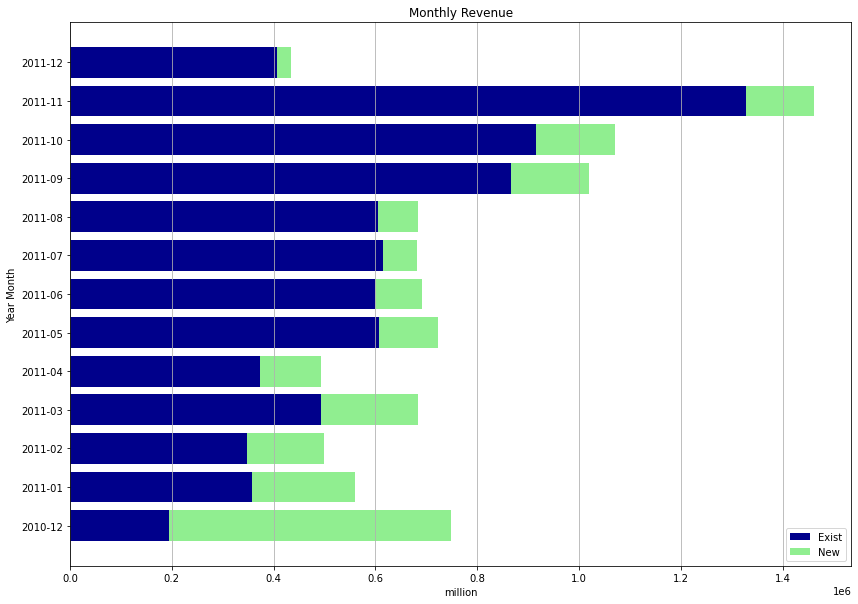

In [5]:
plt.figure(figsize=(14, 10))
plt.barh(rev.index, rev['Exist'], color='darkblue', label='Exist')
plt.barh(rev.index, rev['New'], color='lightgreen', left=rev['Exist'], label='New')
plt.title('Monthly Revenue')
plt.ylabel('Year Month')
plt.xlabel('million')
plt.legend(loc='lower right')
plt.grid(axis='x')

# Monthly Revenue By Cohort

In [6]:
def get_year_month(col, format='%Y-%m'):
    year = pd.to_datetime(col, format=format).dt.year
    month = pd.to_datetime(col, format=format).dt.month
    return year, month

inv_year, inv_month = get_year_month(retail['InvoiceYM'])
signup_year, signup_month = get_year_month(retail['MinYearMonth'])

# divide cohorts by acquisition (unit: month)
retail['CohortID'] = (inv_year-signup_year)*12 + (inv_month-signup_month)

In [7]:
grouping_count = retail.groupby(['InvoiceYM', 'CohortID'])
cohort_data = grouping_count['Revenue'].sum()
cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='InvoiceYM',
                                  columns='CohortID',
                                  values='Revenue')

new_df = pd.DataFrame(index=cohort_counts.index)
for i in range(len(cohort_counts)):
    new_df = new_df.join(cohort_counts.iloc[:, i].shift(-i))

new_df

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
InvoiceYM,,,,,,,,,,,,,
2010-12,554604.020,271616.52,230856.22,302509.39,200927.98,321611.71,312894.36,303907.31,310882.670,466580.68,438835.91,510982.23,182814.95
2011-01,203457.860,56168.55,62264.88,41516.17,82313.31,84009.54,70218.50,72886.27,74430.631,104181.16,122027.20,27850.51,NaN
2011-02,149521.380,25260.26,37456.25,45852.34,35666.69,31081.74,47665.32,55840.13,51861.550,60544.86,9366.67,NaN,NaN
2011-03,189930.080,26383.20,53693.95,40324.05,46759.97,38360.36,60622.28,61705.53,65303.870,11252.28,NaN,NaN,NaN
2011-04,119764.251,28921.03,24928.06,23892.08,26006.54,29653.29,28223.83,33889.78,6292.000,NaN,NaN,NaN,NaN
2011-05,115858.740,17663.95,18876.66,17888.89,26591.53,32951.52,31401.90,10629.02,NaN,NaN,NaN,NaN,NaN
2011-06,92526.510,13619.35,13893.45,29925.03,25835.74,39764.29,7925.61,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,65882.871,11126.27,15395.71,17222.51,19329.06,6056.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,77658.230,19122.50,33061.56,39925.01,14143.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


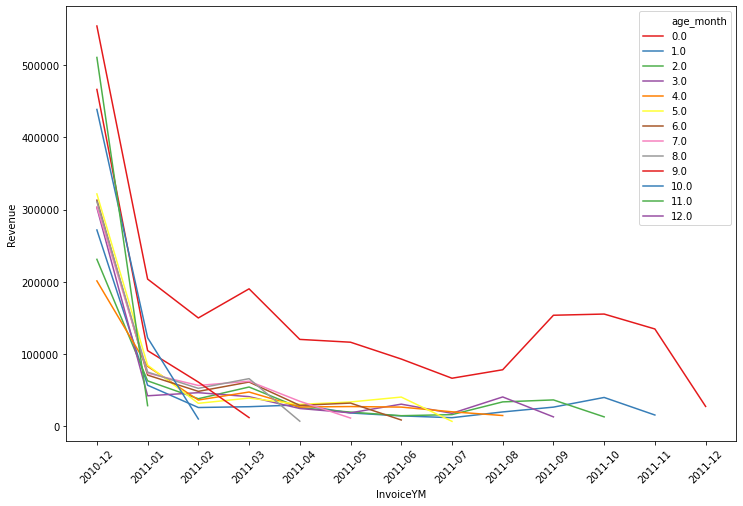

In [8]:
temp = new_df.reset_index()
tem = pd.melt(temp, ['InvoiceYM'], value_name='Revenue', var_name='age_month')

plt.figure(figsize=(12, 8))
sns.lineplot(x='InvoiceYM', y='Revenue', hue='age_month', 
             palette=sns.color_palette('Set1', n_colors=13), data=tem)
plt.xticks(rotation=45)
plt.show()